## Feedbacks visualization
Simple bar graph based on code from IH (the true OG).

In [1]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, re,
    glob
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png, average_and_wrap, mute_ax
    )

from classes import SatComp_Metric, CT_SLF_Metric
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Check running location and adjust working directory appropriately.

In [2]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = 'figures/'
case_dir = 'satcomp/'   # inconsistent label compared to jupy_test
fb_dir ='feedbacks_soden/mod_by_me/output_jonahks/'

# Check that each important directory can be accessed:    
access_paths = os.path.exists(output_dir) and os.path.exists(case_dir) and os.path.exists(fb_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


In [3]:
from feedback_functions import *

### Cloud Amount

### Load CALIOP GOCCP

In [4]:
goccp_dir = 'GOCCP_data/2Ddata/f19_tn14_interpolation/'
#'/nird/home/jonahks/p/jonahks/GOCCP_data/'

# These have an extra dimenson and need to indexed at 0
unvars = ['cllcalipso_un','clmcalipso_un','clhcalipso_un','cltcalipso_un']

if not os.path.exists(goccp_dir):
    print('Could not find GOCCP directory %s' % goccp_dir)
#     return

# Assemble lists for each file type
# Assume that we are using all available files (no need to select by data)

# phase = [] # netCDF files with cloud phase data
cloud = []   # netCDF files with cloud amount data

for year in os.listdir(goccp_dir): # iterate over years (2009-2013)
    _prepath = '%s%s/' % (goccp_dir, year)
    _files = os.listdir(_prepath)

#     _phasefiles = [_prepath + x for x in _files if 'Phase' in x]
    _cloudfiles = [_prepath + x for x in _files if 'MapLowMidHigh330m' in x]

#     phase = phase + _phasefiles
    cloud = cloud + _cloudfiles

# phase.sort()
cloud.sort()

# _phase_ds = xr.open_mfdataset(phase, combine='by_coords')
_cloud_ds = xr.open_mfdataset(cloud, combine='by_coords')
_cloud_ds = _cloud_ds.rename({'cltcalipso':'CLDTOT_CAL'})

### Load CERES-EBAF

In [5]:
ceres_path = 'CERES_EBAF'
ceres_file = 'CERES_EBAF-TOA_Ed4.1_Subset_200003-202002.nc'

_ceres_data = xr.open_dataset('%s/%s' % (ceres_path,ceres_file))

_ceres_data['SWCF'] = (_ceres_data['toa_sw_clr_c_mon'] - _ceres_data['toa_sw_all_mon']).assign_attrs(
            {'units': 'W/m2','long_name': 'Shortwave cloud forcing'})
_ceres_data['LWCF'] = (_ceres_data['toa_lw_clr_c_mon'] - _ceres_data['toa_lw_all_mon']).assign_attrs(
            {'units': 'W/m2','long_name': 'Longwave cloud forcing'})

### Set up to read from model output

In [6]:
zm_dir = '/mnt/mcc-ns9600k/zachary/CESM/'

zm_cases1 = ['cm2000_def_slfout_cosp_1','cm2000_nifix2_slfout_cosp_1']
zm_cases2 = ['cm2000_def_slfout_cosp_sst4k_1','cm2000_nifix2_slfout_cosp_sst4k_1']

In [9]:
# Testing something to order cases and label them.
label_dict = {}
label_dict['cm2000_def_slfout_cosp_1'] = "CESM2"
label_dict['cm2000_nifix2_slfout_cosp_1'] = "CESM2-NIfix2"

In [7]:
cesm_vars = {}

for i in zm_cases1:
#     print(os.listdir('%s/%s' % (zm_dir,i)))
    files = glob.glob('%s/%s/run/*' % (zm_dir,i))
    _bdf = xr.open_mfdataset(files,combine='by_coords')
    _bdf['time'] = _bdf['time_bnds'].isel(nbnd=0)
    _vars = add_weights(_bdf[['CLDTOT_CAL','SWCF','LWCF']]) # easy to add more variables here
    _vars = _vars.sel(time = slice('0001-01-01','0003-12-01'))
    cesm_vars[i] = _vars
    
    _bdf.close()
#     break

### Look at clouds

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5,0.98,'Cloud Cover')

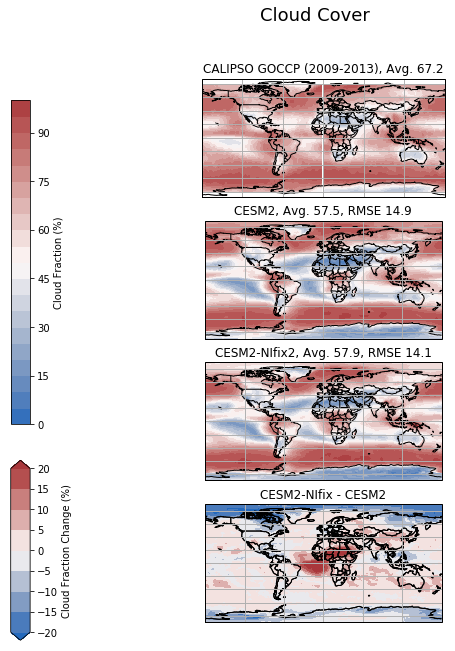

In [30]:
fig0,axs0 = sp_map(nrows=4, ncols=1, projection=ccrs.PlateCarree(), figsize=(9,10))


goccp_cldtot = add_weights(100*_cloud_ds['CLDTOT_CAL'].mean(['time']).interp_like(cesm_vars['cm2000_def_slfout_cosp_1']['CLDTOT_CAL']))
goccp_cldavg = masked_average(goccp_cldtot,dim=['lat','lon'],weights=goccp_cldtot['cell_weight'])

_im = axs0[0].contourf(goccp_cldtot['lon'],goccp_cldtot['lat'],goccp_cldtot,levels=np.linspace(0,100,21),extend='neither',cmap='vlag')
add_map_features(axs0[0])
axs0[0].set_title('CALIPSO GOCCP (2009-2013), Avg. %.1f' % goccp_cldavg)
    
for i,key in enumerate(cesm_vars):
    i+=1
    
    _ds = cesm_vars[key]
    
    _cldtot = add_weights(_ds['CLDTOT_CAL'].mean('time'))
    _cldtot_avg = masked_average(_cldtot,dim=['lat','lon'],weights=_cldtot['cell_weight'])
    _cldtot_rmse = np.sqrt(masked_average((_cldtot - goccp_cldtot)**2,dim=['lat','lon'],weights=_cldtot['cell_weight']))
#     _cldtot2 = _cldtot.mean('lon')
            
    _im = axs0[i].contourf(_cldtot['lon'],_cldtot['lat'],_cldtot,levels=np.linspace(0,100,21),extend='neither',cmap='vlag')
    add_map_features(axs0[i])
    axs0[i].set_title('%s, Avg. %.1f, RMSE %.1f' %(label_dict[key],_cldtot_avg,_cldtot_rmse))
    
    if i == 0:
        _cldtot0 = _cldtot
#         _cldtot20 = _cldtot2
    else:
        diff_cldtot = _cldtot - _cldtot0
#         diff_cldtot2 = _cldtot2 - _cldtot20
    
        _im0 = axs0[-1].contourf(_cldtot['lon'],_cldtot['lat'],diff_cldtot,
                                  levels=np.linspace(-20,20,9),extend='both',cmap='vlag')
        add_map_features(axs0[-1])
        axs0[-1].set_title('CESM2-NIfix - CESM2')
        
cbar_axv1 = fig0.add_axes([0.03, 0.4, 0.03, 0.45])
cbar_axv2 = fig0.add_axes([0.03, 0.1, 0.03, 0.25])
fig0.colorbar(_im,label='Cloud Fraction (%)',cax=cbar_axv1,orientation='vertical')
fig0.colorbar(_im0,label='Cloud Fraction Change (%)',cax=cbar_axv2,orientation='vertical')
fig0.suptitle('Cloud Cover',fontsize=18)

/opt/conda/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


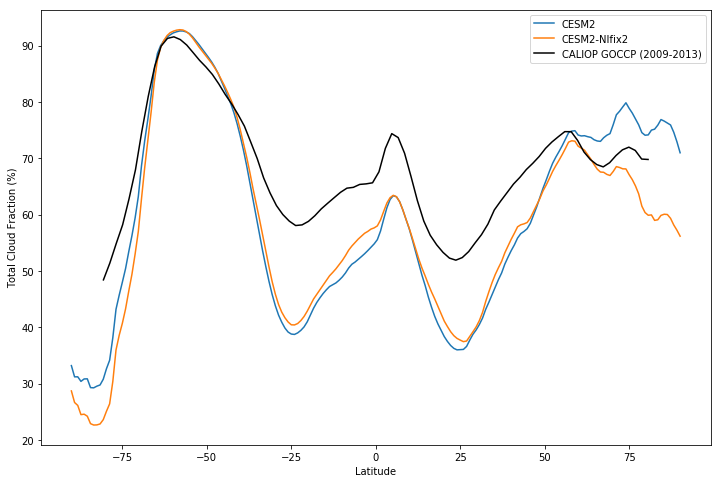

In [16]:
fig0b,axs0b = plt.subplots(1,1, figsize=(12,8))
# fig0b,axs0b = sp_map(nrows=1, ncols=1,
#                            projection=ccrs.PlateCarree(), figsize=(9,10))

# axs2[0].set_title('SW Feedback')
# axs2[1].set_title('LW Feedback')

axs0b.set_xlabel('Latitude')
axs0b.set_ylabel('Total Cloud Fraction (%)')

for i,key in enumerate(cesm_vars):

    _ds = cesm_vars[key]
    
    _cldtot = _ds['CLDTOT_CAL'].mean('time')
    _cldtot2 = _cldtot.mean('lon')
    
    _im = axs0b.plot(_cldtot2['lat'],_cldtot2,label='%s' % (label_dict[key]))
#     _im = axs2[1].plot(_lwfb2['lat'],_lwfb2,label='%s' % (label_dict[key]))

goccp_cldtot = _cloud_ds['CLDTOT_CAL'].mean(['time','lon'])*100
_im = axs0b.plot(goccp_cldtot['lat'],goccp_cldtot,label='CALIOP GOCCP (2009-2013)',color='black')

# _cloud_ds

plt.legend(loc='upper right')

### Look at Cloud Radiative Forcing

Text(0.5,0.98,'Cloud Forcings')

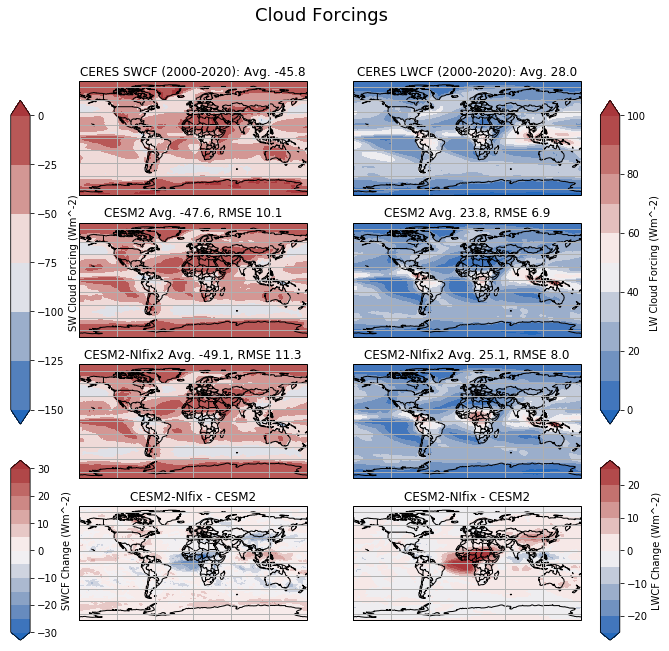

In [31]:
fig0,axs0 = sp_map(nrows=4, ncols=2,
                           projection=ccrs.PlateCarree(), figsize=(9,10))


ceres_swcf = _ceres_data['SWCF'].mean('time')
ceres_swcf_grid = add_weights(ceres_swcf.interp_like(cesm_vars['cm2000_def_slfout_cosp_1']['SWCF']))
ceres_lwcf = _ceres_data['LWCF'].mean('time')
ceres_lwcf_grid = add_weights(ceres_lwcf.interp_like(cesm_vars['cm2000_def_slfout_cosp_1']['LWCF']))

ceres_swcf_avg = masked_average(ceres_swcf_grid,dim=['lat','lon'],weights=ceres_swcf_grid['cell_weight'])
ceres_lwcf_avg = masked_average(ceres_lwcf_grid,dim=['lat','lon'],weights=ceres_swcf_grid['cell_weight'])

axs0[0,0].contourf(ceres_swcf['lon'],ceres_swcf['lat'],ceres_swcf,levels=np.linspace(-150,0,7),extend='both',cmap='vlag')
axs0[0,1].contourf(ceres_lwcf['lon'],ceres_lwcf['lat'],ceres_lwcf,levels=np.linspace(0,100,11),extend='both',cmap='vlag')
add_map_features(axs0[0,0])
add_map_features(axs0[0,1])

axs0[0,0].set_title('CERES SWCF (2000-2020): Avg. %.1f' % ceres_swcf_avg)
axs0[0,1].set_title('CERES LWCF (2000-2020): Avg. %.1f' % ceres_lwcf_avg)

for i,key in enumerate(cesm_vars):
    i+=1
    _ds = cesm_vars[key]
    
    _swcf = add_weights(_ds['SWCF'].mean('time'))
    _lwcf = add_weights(_ds['LWCF'].mean('time'))
    
    _swcf_mean = masked_average(_swcf,dim=['lat','lon'],weights=_swcf['cell_weight'])
    _lwcf_mean = masked_average(_lwcf,dim=['lat','lon'],weights=_lwcf['cell_weight'])
    
    _swcf_rmse = np.sqrt(masked_average((_swcf - ceres_swcf_grid)**2,dim=['lat','lon'],weights=_swcf['cell_weight']))
    _lwcf_rmse = np.sqrt(masked_average((_lwcf - ceres_lwcf_grid)**2,dim=['lat','lon'],weights=_lwcf['cell_weight']))
            
    _im_sw = axs0[i,0].contourf(_swcf['lon'],_swcf['lat'],_swcf,levels=np.linspace(-150,0,7),extend='both',cmap='vlag')
    _im_lw = axs0[i,1].contourf(_lwcf['lon'],_lwcf['lat'],_lwcf,levels=np.linspace(0,100,11),extend='both',cmap='vlag')
    add_map_features(axs0[i,0])
    add_map_features(axs0[i,1])
    
    axs0[i,0].set_title('%s Avg. %.1f, RMSE %.1f' % (label_dict[key],_swcf_mean,_swcf_rmse))
    axs0[i,1].set_title('%s Avg. %.1f, RMSE %.1f' % (label_dict[key],_lwcf_mean,_lwcf_rmse))
    
    if i == 1:
        _swcf0 = _swcf
        _lwcf0 = _lwcf
    else:
        diff_swcf = _swcf - _swcf0
        diff_lwcf = _lwcf - _lwcf0
    
        _im0sw = axs0[-1,0].contourf(_swcf['lon'],_swcf['lat'],diff_swcf,
                                 levels=np.linspace(-30,30,13),extend='both',cmap='vlag')
        _im0lw = axs0[-1,1].contourf(_lwcf['lon'],_lwcf['lat'],diff_lwcf,
                                 levels=np.linspace(-25,25,11),extend='both',cmap='vlag')
        add_map_features(axs0[-1,0])
        add_map_features(axs0[-1,1])
        
        axs0[-1,0].set_title('CESM2-NIfix - CESM2')
        axs0[-1,1].set_title('CESM2-NIfix - CESM2')

cbar_axv1 = fig0.add_axes([0.02, 0.4, 0.03, 0.45])
cbar_axv2 = fig0.add_axes([0.02, 0.1, 0.03, 0.25])

cbar_axv1b = fig0.add_axes([0.93, 0.4, 0.03, 0.45])
cbar_axv2b = fig0.add_axes([0.93, 0.1, 0.03, 0.25])

fig0.colorbar(_im_sw,label='SW Cloud Forcing (Wm^-2)',cax=cbar_axv1,orientation='vertical')
fig0.colorbar(_im_lw,label='LW Cloud Forcing (Wm^-2)',cax=cbar_axv1b,orientation='vertical')

fig0.colorbar(_im0sw,label='SWCF Change (Wm^-2)',cax=cbar_axv2,orientation='vertical')
fig0.colorbar(_im0lw,label='LWCF Change (Wm^-2)',cax=cbar_axv2b,orientation='vertical')

fig0.suptitle('Cloud Forcings',fontsize=18)

### TOA Feedbacks

In [33]:
cases = os.listdir(fb_dir)
case_dict = {} # Cases are keys, feedback dictionaries are values


for _case in cases:
    if ("cm2000" in _case): # Filter SFC kernels    
        print(_case)
        case_dict[_case] = org_feedbacks_case(_case)

cm2000_def_slfout_cosp_1
cm2000_nifix2_slfout_cosp_1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5,0.98,'Cloud Feedbacks')

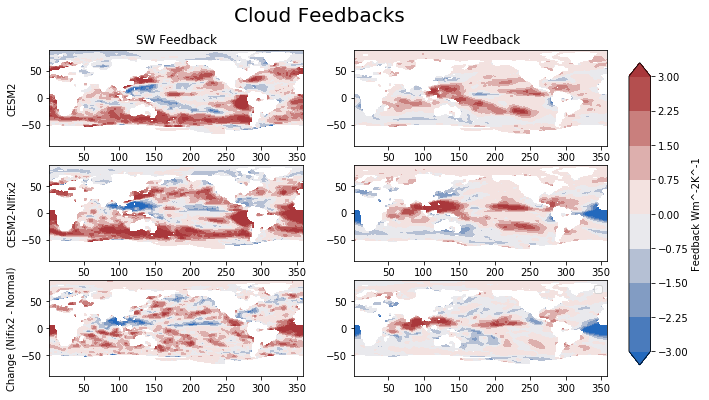

In [34]:
fig1,axs1 = plt.subplots(3,2,figsize=(10,6))

axs1[0,0].set_title('SW Feedback')
axs1[0,1].set_title('LW Feedback')

for i,key in enumerate(case_dict):

    _ds = case_dict[key]
    
    _swfb = _ds['fb_adj_cloud_sw'].mean('month')
    _lwfb = _ds['fb_adj_cloud_lw'].mean('month')
    
    _swfb2 = _swfb.mean('lon')
    _lwfb2 = _lwfb.mean('lon')
    
    _im = axs1[i,0].contourf(_swfb['lon'],_swfb['lat'],_swfb,levels=np.linspace(-3,3,9),extend='both',cmap='vlag')
    _im = axs1[i,1].contourf(_lwfb['lon'],_lwfb['lat'],_lwfb,levels=np.linspace(-3,3,9),extend='both',cmap='vlag')#,cmap=cmaps.ncl_default)

    axs1[i,0].set_ylabel('%s' % label_dict[key])
    
    plt.legend(loc='upper right')
    
    if i == 0:
        init_sw0 = _swfb
        init_lw0 = _lwfb
    else:        
        _im = axs1[-1,0].contourf(_swfb['lon'],_swfb['lat'],_swfb-init_sw0,levels=np.linspace(-3,3,9),extend='both',cmap='vlag')
        _im = axs1[-1,1].contourf(_lwfb['lon'],_lwfb['lat'],_lwfb-init_lw0,levels=np.linspace(-3,3,9),extend='both',cmap='vlag')
        
cbar_axh1 = fig1.add_axes([0.93, 0.15, 0.03, 0.7])
fig1.colorbar(_im,label='Feedback Wm^-2K^-1',cax=cbar_axh1,orientation='vertical')
axs1[-1,0].set_ylabel('Change (Nifix2 - Normal)')

fig1.suptitle('Cloud Feedbacks',fontsize=20)

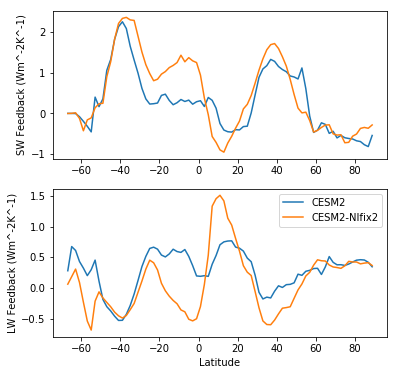

In [39]:
fig2,axs2 = plt.subplots(2,1,figsize=(6,6))

# axs2[0].set_title('SW Feedback')
# axs2[1].set_title('LW Feedback')

axs2[1].set_xlabel('Latitude')
axs2[0].set_ylabel('SW Feedback (Wm^-2K^-1)')
axs2[1].set_ylabel('LW Feedback (Wm^-2K^-1)')

for i,key in enumerate(case_dict):

    _ds = case_dict[key]
    
    _swfb = _ds['fb_adj_cloud_sw'].mean('month')
    _lwfb = _ds['fb_adj_cloud_lw'].mean('month')
    
    _swfb2 = _swfb.mean('lon')
    _lwfb2 = _lwfb.mean('lon')

    _im = axs2[0].plot(_swfb2['lat'],_swfb2,label='%s' % (label_dict[key]))
    _im = axs2[1].plot(_lwfb2['lat'],_lwfb2,label='%s' % (label_dict[key]))
    
    plt.legend(loc='upper right')

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
No handles with labels found to put in legend.
No handles with labels found to put in legend.


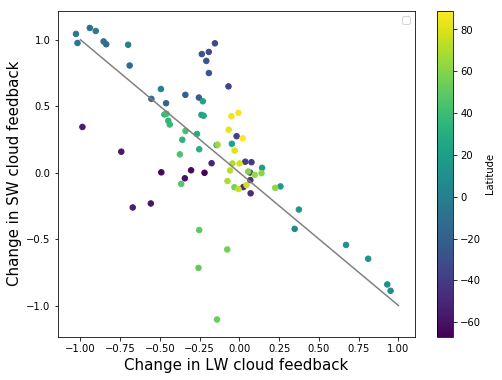

In [37]:
fig3,ax3 = plt.subplots(1,1,figsize=(8,6))

for i,key in enumerate(case_dict):

    _ds = case_dict[key]
    
    _swfb = _ds['fb_adj_cloud_sw'].mean('month')
    _lwfb = _ds['fb_adj_cloud_lw'].mean('month')
    
    _swfb2 = _swfb.mean('lon')
    _lwfb2 = _lwfb.mean('lon')
    
    plt.legend(loc='upper right')
    if i != len(case_dict) - 1: # bad way to get the last entry
        init_sw = _swfb2
        init_lw = _lwfb2
    else:
        diff_sw = _swfb2 - init_sw
        diff_lw = _lwfb2 - init_lw
        rng = np.linspace(-1,1,100) 
        ax3.plot(rng,-1*rng,c='gray')
        sc = ax3.scatter(diff_lw,diff_sw,s=30,c=diff_lw['lat'], marker = 'o', cmap = 'viridis')#,levels=np.linspace(-90,90,19) )
        ax3.set_xlabel('Change in LW cloud feedback',fontsize=15)
        ax3.set_ylabel('Change in SW cloud feedback',fontsize=15)
        
plt.colorbar(sc,label='Latitude') 

## Why is the southern ocean devoid of values? I'm sure that it has something to do with how the cloud feedbacks are calculated via Soden.

In [5]:
# Testing something to order cases and label them.
label_dict = {}
label_dict['cm2000_def_slfout_cosp_1'] = "CESM2"
label_dict['cm2000_nifix2_slfout_cosp_1'] = "CESM2-NIfix2"

In [6]:
out = weight_feedbacks(case_dict,lat_range=[-90,90])

cm2000_def_slfout_cosp_1
cm2000_nifix2_slfout_cosp_1


In [7]:
out

{'planck_fb': [array(-3.15634796), array(-3.1553143)],
 'lapserate_fb': [array(-0.77487399), array(-0.72169527)],
 'watervapor_fb': [1.98635949837669, 1.9311312026691838],
 'albedo_fb': [array(0.16574323), array(0.16803847)],
 'cloudsw_fb': [array(0.47927519), array(0.79388669)],
 'cloudlw_fb': [array(0.284898), array(0.09742354)]}

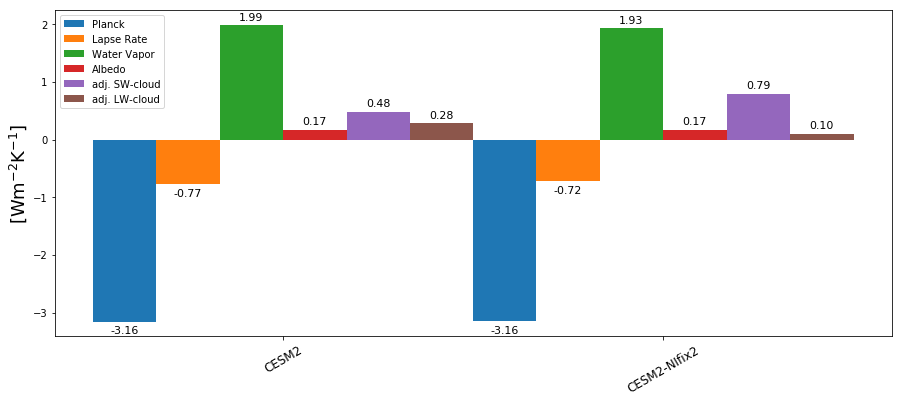

In [7]:
plt1 = barplot_feedbacks1(case_dict,out,labels=label_dict)

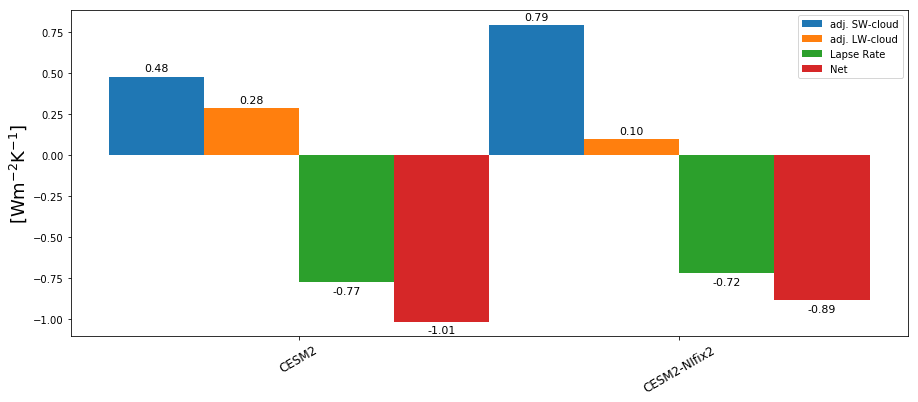

In [8]:
plt2 = barplot_feedbacks2(case_dict,out,labels=label_dict)

(<Figure size 576x432 with 1 Axes>,
 {'cm2000_def_slfout_cosp_1': array(0.47927519),
  'cm2000_nifix2_slfout_cosp_1': array(0.79388669)})

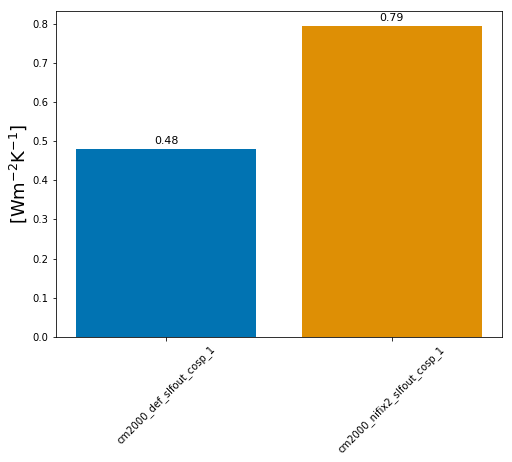

In [9]:
barplot_single(case_dict,out,'cloudsw_fb')

(<Figure size 576x432 with 1 Axes>,
 {'cm2000_def_slfout_cosp_1': array(0.284898),
  'cm2000_nifix2_slfout_cosp_1': array(0.09742354)})

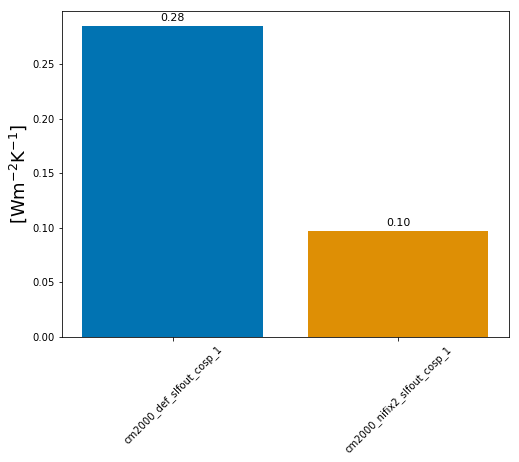

In [10]:
barplot_single(case_dict,out,'cloudlw_fb')

In [72]:
to_png(out[0],"CESM_nifix_feedbacks")

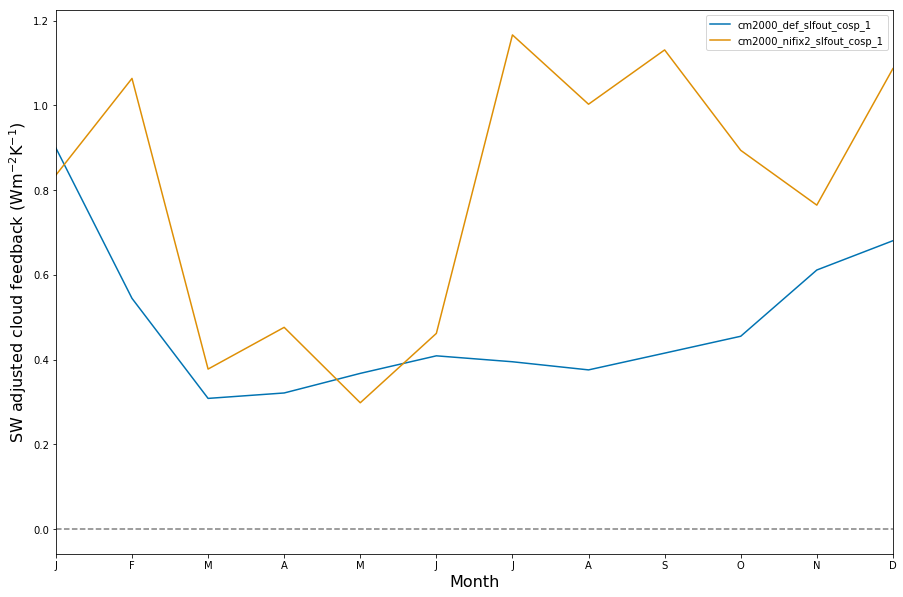

In [27]:
fig_out,axes_out = plot_months_line(case_dict,'fb_adj_cloud_sw',lat_range=[-90,90])
